<a href="https://colab.research.google.com/github/larasauser/master/blob/main/nspi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NSPI V2 - based on Chen et al (2011).

In [1]:
!pip install rasterio
!pip install numpy
!pip install opencv-python
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import rasterio
from rasterio.plot import show
import cv2
import tqdm
from math import sqrt
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import rasterio
from matplotlib import cm

In [3]:
def compute_rmsd(p1, p2):
    return np.sqrt(np.nanmean(p1-p2)**2)

In [4]:
def select_similar_pixels(input_patch, target_patch, gap_mask, stds, m, max_window):
  h,w,b = input_patch.shape
  x_c,y_c = h//2,w//2
  target_pixel = input_patch[x_c,y_c]

  if np.isnan(target_pixel).any():
        return [], []

  similar_pixels = []
  distances = []

  for i in range(h):
    for j in range(w):
      if gap_mask[i,j]:
        continue

      candidate = input_patch[i,j]

      if np.isnan(candidate).any():
        continue
      rmsd = np.sqrt(np.mean((candidate - target_pixel) ** 2))
      threshold = np.sum([2*stds[k]/m for k in range(b)])/b
      if rmsd <= threshold:
          similar_pixels.append(((i,j),candidate))
          distances.append(np.linalg.norm([i-x_c, j-y_c]))
  return similar_pixels, distances

In [5]:
def predict_pixel_value(similar_pixels, distances, input_patch, target_patch, stds, m, max_window, input_central, target_central):
  if len(similar_pixels)==0:
    return None #use histogram matching if no similar pixel available

  rmsds = [compute_rmsd(input_patch[i,j],input_central) for (i,j),_ in similar_pixels]
  cds = [r*d for r,d in zip(rmsds,distances)]
  weights = 1/(np.array(cds)+1e-6)
  weights /=weights.sum()

  #Prediction L1
  L1 = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    L1 += w*target_patch[i,j]

  #Prediction L2
  delta = np.zeros_like(input_central)
  for w, ((i,j),_) in zip(weights, similar_pixels):
    delta += w * (target_patch[i,j]-input_patch[i,j])
  L2 = input_central + delta

  #Final ponderation T1,T2
  R1 = np.mean([compute_rmsd(input_patch[i,j], input_central)for (i,j),_ in similar_pixels])
  R2 = np.mean([compute_rmsd(target_patch[i,j],input_patch[i,j])for (i,j),_ in similar_pixels])

  T1 = 1/R1 if R1 != 0 else 1e6
  T2 = 1/R2 if R2 != 0 else 1e6
  T_sum = T1 + T2
  T1, T2 = T1/T_sum, T2/T_sum

  return T1*L1 + T2*L2

In [6]:
def filled_gaps_nspi(target, input_shape, gap_mask, m=20, max_window =151):
  filled = target.copy()
  h,w,b = target.shape
  pad = max_window//2
  padded_target = np.pad(target, ((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_input = np.pad(input_image,((pad,pad),(pad,pad),(0,0)),mode='reflect')
  padded_mask = np.pad(gap_mask,((pad,pad),(pad,pad)),mode='constant',constant_values=1)

  stds = np.nanstd(input_image[~gap_mask],axis=0)

  for y in tqdm(range(pad,pad+h)):
    for x in range(pad,pad+w):
      if not gap_mask[y-pad,x-pad]:
        continue

      for window in range(26, max_window +2, 4):
        r = window//2
        input_patch = padded_input[y-r:y+r+1, x-r:x+r+1]
        target_patch = padded_target[y-r:y+r+1, x-r:x+r+1]
        mask_patch = padded_mask[y-r:y+r+1, x-r:x+r+1]

        similar_pixels, distances = select_similar_pixels(
            input_patch, target_patch, mask_patch, stds, m, max_window
        )

        if len(similar_pixels) >= m or window == max_window:
          val = predict_pixel_value(similar_pixels, distances, input_patch, target_patch,stds,m,max_window,
                                    input_patch[r,r], target_patch[r,r])
          if val is not None:
            filled[y-pad,x-pad] = val
          break

  return filled


In [7]:
def visu_2(input_img, target_img, input_path, target_path, band=0):
     # Récupération des noms
    input_name = os.path.splitext(os.path.basename(input_path))[0]
    target_name = os.path.splitext(os.path.basename(target_path))[0]

    # Ouverture pour extent et CRS
    with rasterio.open(input_path) as src:
        bounds = src.bounds
        crs = src.crs

    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    vmin, vmax = -1, 1

    # Préparer le colormap avec gaps en noir
    cmap = cm.get_cmap("RdYlGn").copy()
    cmap.set_bad(color="black")  # pour les NaN

    # Remplacer les valeurs -9999 par NaN
    input_band = np.where(input_img[:, :, band] == -9999, np.nan, input_img[:, :, band])
    target_band = np.where(target_img[:, :, band] == -9999, np.nan, target_img[:, :, band])

    fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

    # Première image (ground truth)
    im1 = axes[0].imshow(input_band, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
    axes[0].set_title(f"Ground truth - {input_name}", fontsize=20, fontweight='bold', pad=15)
    axes[0].set_xlabel(f"X ({crs})", fontsize=14, fontweight='bold')
    axes[0].set_ylabel(f"Y ({crs})", fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='both', which='major', labelsize=14)

    # Deuxième image (avec trous)
    im2 = axes[1].imshow(target_band, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
    axes[1].set_title(f"Gaps - {target_name}", fontsize=20, fontweight='bold', pad=15)
    axes[1].set_xlabel(f"X ({crs})", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("")  # éviter la répétition
    axes[1].tick_params(axis='both', which='major', labelsize=14)

    # Une seule barre de couleur commune
    cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
    cbar.set_label("NDVI", fontsize=16, fontweight="bold")
    cbar.ax.tick_params(labelsize=14)

    plt.show()

## Application

In [8]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [227]:
#Choose image to compute HERENS
input_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/NDVI_2018-10-09.tif'
target_path = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/NDVI_2018-10-09.tif'

In [130]:
#Choose image to compute GRANCY
input_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2023-11-08.tif'
target_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes/NDVI_2023-11-08.tif'

In [228]:
import rasterio
import numpy as np

with rasterio.open(input_path) as src:
  input_image=src.read().transpose(1,2,0).astype(np.float32)
  input_profile = src.profile

with rasterio.open(target_path) as src:
  target_image = src.read().transpose(1,2,0).astype(np.float32)
  target_profile = src.profile

/tmp/ipython-input-585176755.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn").copy()


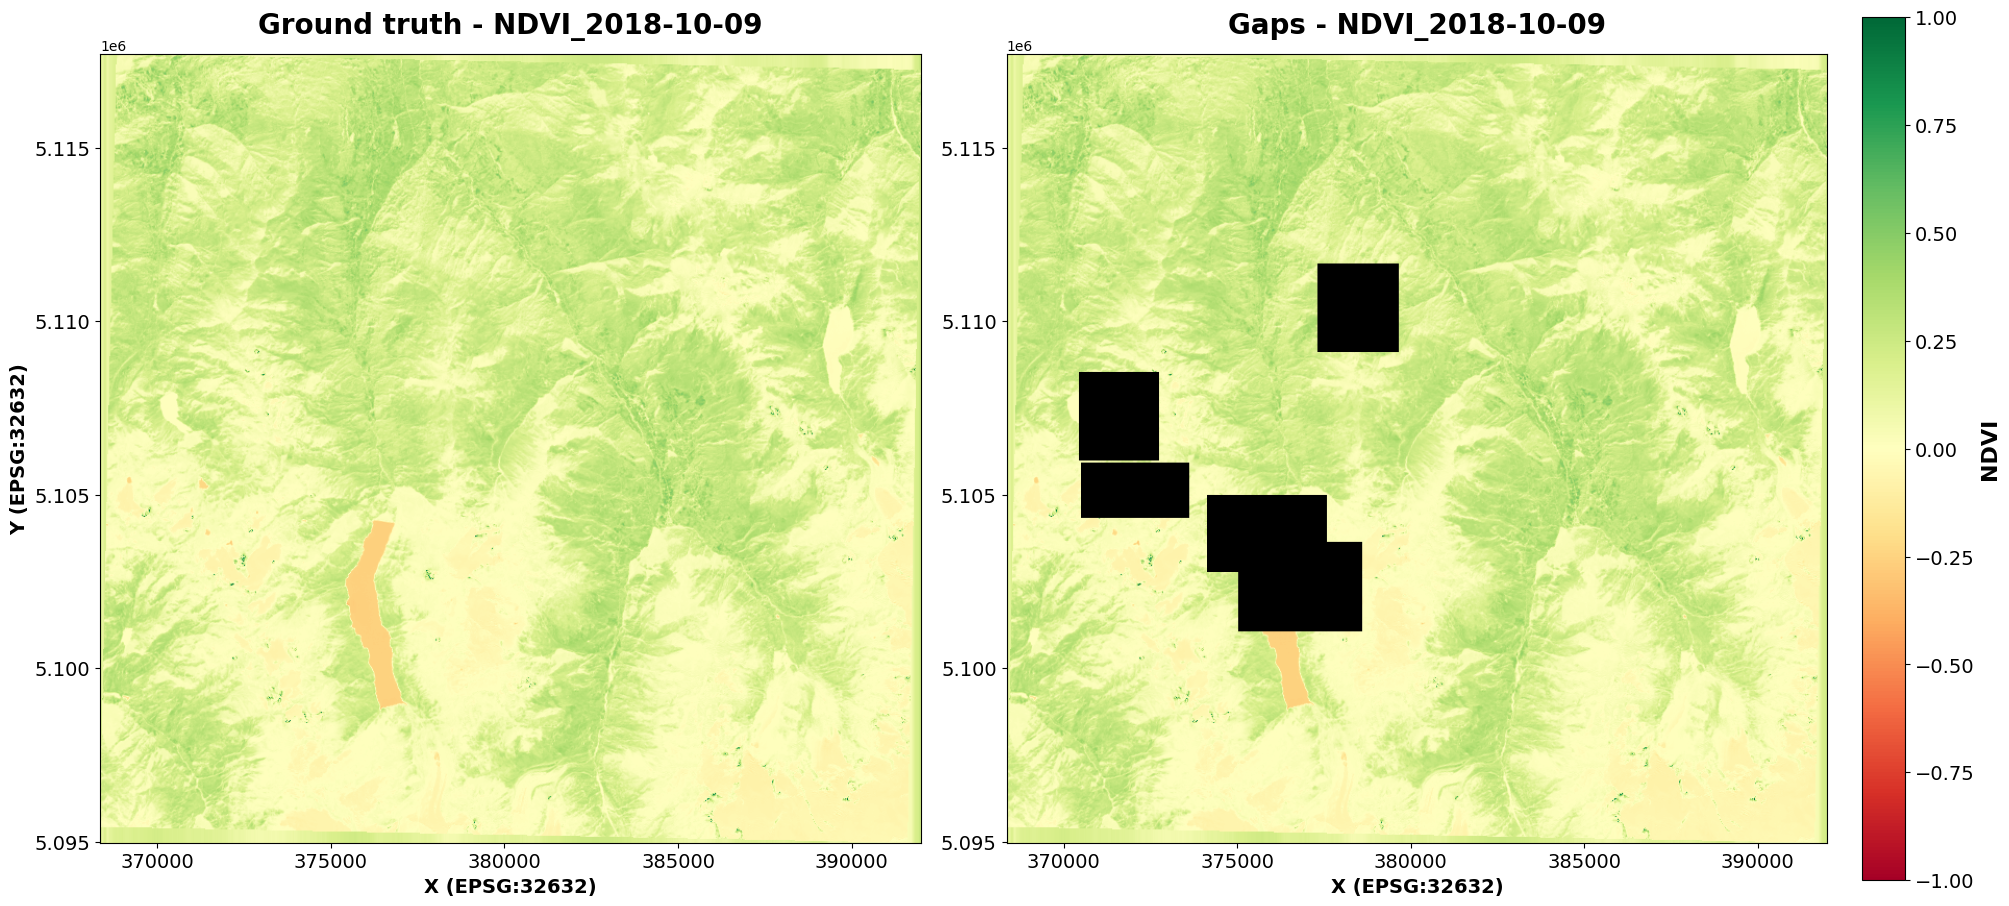

In [229]:
#Visualise original image
visu_2(input_image, target_image, input_path, target_path, band=0)

In [230]:
count = np.sum(target_image == -9999)
print("-9999 Occurences :", count)

-9999 Occurences : 34966


In [231]:
target_image[target_image == -9999] = np.nan

In [232]:
np.isnan(target_image).any()

np.True_

In [233]:
gap_mask = np.isnan(target_image[:,:,0])

In [234]:
filled_img = filled_gaps_nspi(target_image, input_image, gap_mask, m=20, max_window = 151) #Change window max according to Hérens (151) and Grancy (76)

100%|██████████| 757/757 [1:11:44<00:00,  5.69s/it]


In [60]:
import matplotlib.pyplot as plt
import numpy as np

def show_comparison(input_image, target_image, filled_img, band=0):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    vmin, vmax = -1, 1

    titles = ['Ground truth', 'Gaps', 'Gap-filled']
    images = [input_image, target_image, filled_img]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img[:, :, band], cmap='RdYlGn', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


In [49]:
import matplotlib.pyplot as plt
import rasterio
import os

def show_comparison_(input_img, target_img, filled_img, input_path, band=0):

    image_name = os.path.splitext(os.path.basename(input_path))[0]

    with rasterio.open(input_path) as src:
        bounds = src.bounds
        crs = src.crs

    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    fig, axes = plt.subplots(1, 3, figsize=(22, 8), constrained_layout=True, sharey=True)

    vmin, vmax = -1, 1
    titles = [f"Ground truth - {image_name}", 'Gaps', 'Gap-filled']
    images = [input_img, target_img, filled_img]

    ims = []
    for i, (ax, img, title) in enumerate(zip(axes, images, titles)):
        im = ax.imshow(img[:, :, band], cmap='RdYlGn',
                       vmin=vmin, vmax=vmax, extent=extent)
        ax.set_title(title, fontsize=22, fontweight='bold', pad = 15)
        ax.set_xlabel(f"X ({crs})", fontsize=14, fontweight='bold')

        if i == 0:
            ax.set_ylabel(f"Y ({crs})", fontsize=16, fontweight='bold')
        else:
            ax.set_ylabel("")
            ax.tick_params(labelleft=False)

        ax.tick_params(axis='both', which='major', labelsize=16)
        ims.append(im)

    cbar = fig.colorbar(ims[0], ax=axes, orientation='vertical',
                        fraction=0.025, pad=0.02)
    cbar.set_label("NDVI", fontsize=16, fontweight="bold")
    cbar.ax.tick_params(labelsize=14)

    return fig

In [235]:
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/filled_nspi2/subplot'
os.makedirs(output_dir, exist_ok=True)

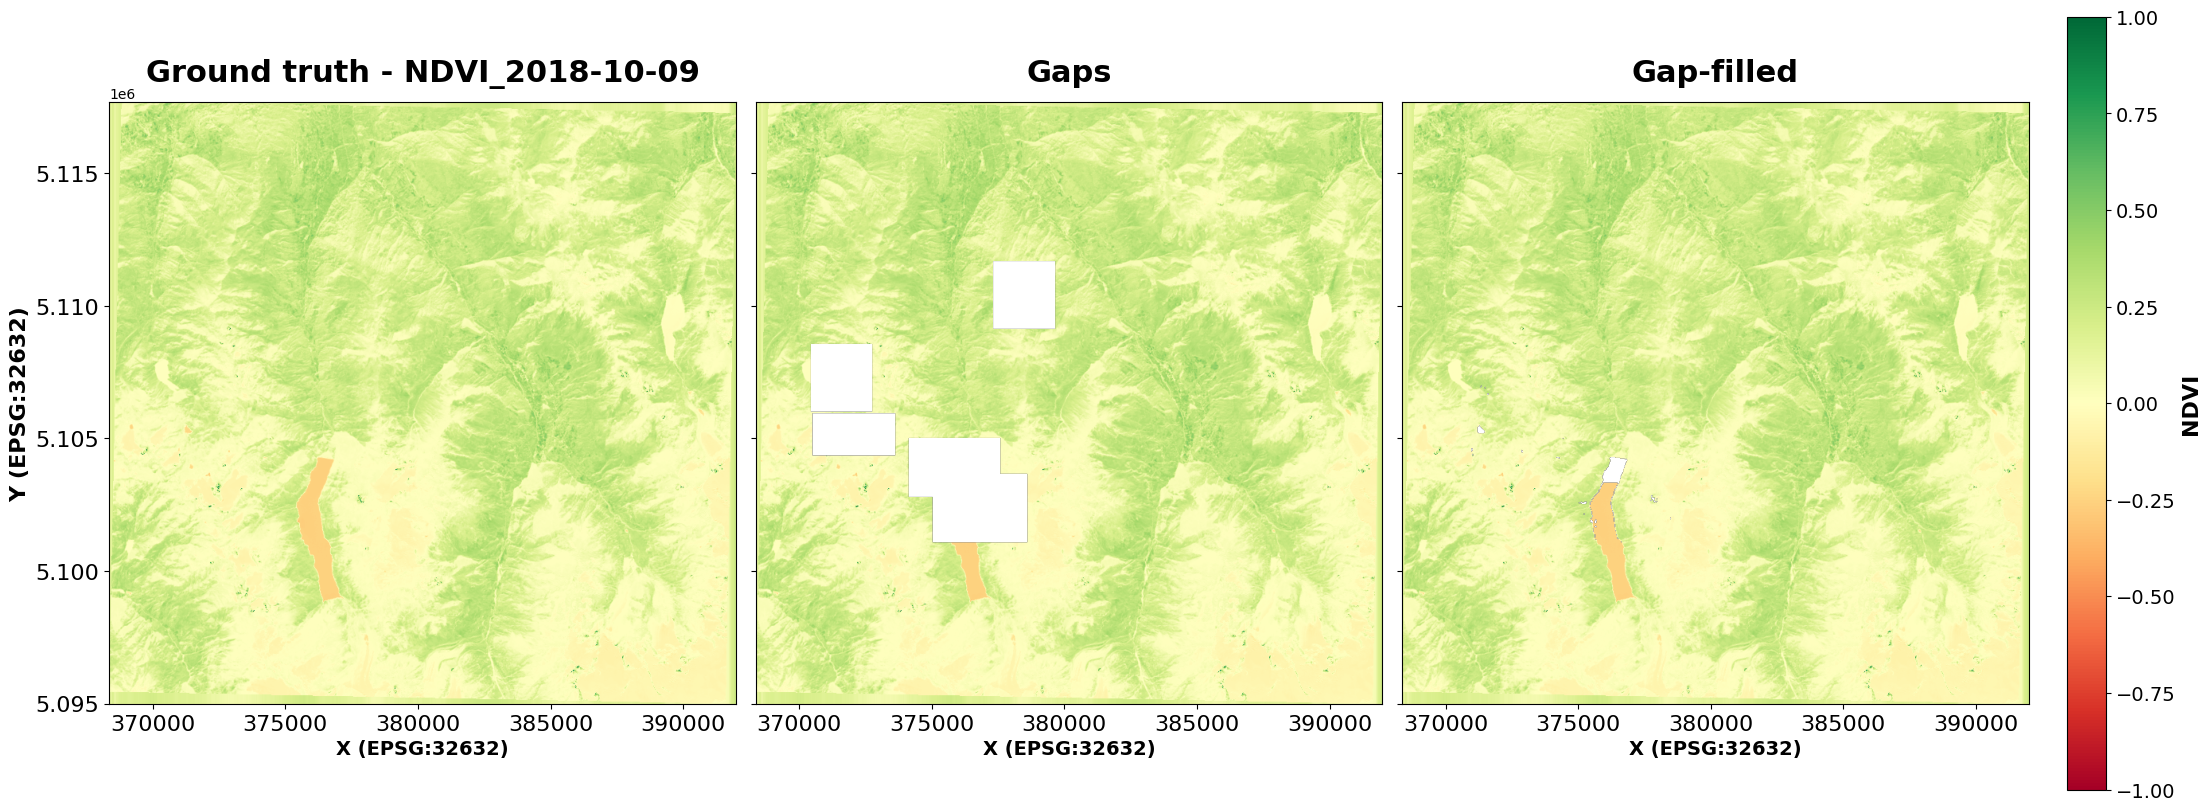

In [236]:
fig = show_comparison_(input_image, target_image, filled_img,input_path, band=0)

In [237]:
output_path = os.path.join(output_dir, f"{os.path.basename(input_path).replace('.tif', '')}_subplot.png")
fig.savefig(output_path, dpi=300, bbox_inches="tight")


## Export

In [238]:
import os
from skimage.io import imsave

In [239]:
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/filled_nspi2'
os.makedirs(output_dir, exist_ok=True)

In [240]:
filename = "NDVI_2018-10-09.tif"
output_path = os.path.join(output_dir, filename)

In [241]:
imsave(output_path, filled_img)
print(f"Image saved at: {output_path}")

Image saved at: /content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes/filled_nspi2/NDVI_2018-10-09.tif


## Metrics


In [67]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.5 MB/s eta 0:00:00


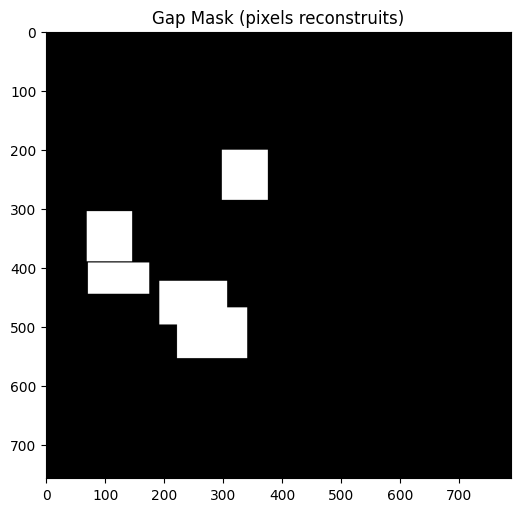

In [242]:
#Verify that the mask is correct
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.title("Gap Mask (pixels reconstruits)")
plt.imshow(gap_mask, cmap='gray')
plt.show()


In [243]:
filled_img = np.squeeze(filled_img)
input_img = np.squeeze(input_image)

In [88]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import piq
import torch

def evaluate_nspi_metrics(input_image, filled_img, gap_mask, image_name):
    """
    Evaluates gap-filling quality using standard metrics.
    Uses the zero-fill method for MS-SSIM calculation.
    """
    input_image = np.squeeze(np.array(input_image))
    filled_img = np.squeeze(np.array(filled_img))
    gap_mask = np.squeeze(np.array(gap_mask)).astype(bool)

    if input_image.shape != filled_img.shape or input_image.shape != gap_mask.shape:
        raise ValueError(f"Incompatible shapes: {input_image.shape}, {filled_img.shape}, {gap_mask.shape}")

    valid_mask = gap_mask & ~np.isnan(input_image) & ~np.isnan(filled_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    # --- Error-based Metrics (RMSE, R², MAE) ---
    y_true = input_image[valid_mask]
    y_pred = filled_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    if np.var(y_true) < 1e-8:
        r2 = np.nan
    else:
        r2 = r2_score(y_true, y_pred)

    mae = np.mean(np.abs(y_true - y_pred))

    # --- MS-SSIM ---
    min_val = np.nanmin([input_image[valid_mask], filled_img[valid_mask]])
    max_val = np.nanmax([input_image[valid_mask], filled_img[valid_mask]])

    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        input_norm = (input_image - min_val) / (max_val - min_val)
        filled_norm = (filled_img - min_val) / (max_val - min_val)

        input_norm[~valid_mask] = 0.0
        filled_norm[~valid_mask] = 0.0

        input_tensor = torch.from_numpy(input_norm).unsqueeze(0).unsqueeze(0).float()
        filled_tensor = torch.from_numpy(filled_norm).unsqueeze(0).unsqueeze(0).float()

        ms_ssim_score = piq.multi_scale_ssim(
            input_tensor, filled_tensor, data_range=1., reduction='none'
        ).item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }
    return pd.DataFrame([results])

In [244]:
df = evaluate_nspi_metrics(input_image, filled_img, gap_mask, "NDVI_2017-08-26")
df

,Image name,RMSE,R²,MAE,MS-SSIM,% reconstructed pixels
0,NDVI_2017-08-26,2.068176e-07,1.0,1.241826e-07,1.0,97.368873


In [ ]:
print("input_image:", input_img.shape)
print("filled_img:", filled_img.shape)
print("gap_mask:", gap_mask.shape)

input_image: (347, 322)
filled_img: (347, 322)
gap_mask: (347, 322)
